# Mecklenburg Zip Codes Boundaries

#### Author : Sumit Chhabra

In [1]:
#install folium in IBM Watson Studio
#skip this step if already installed
!conda install -c conda-forge folium=0.5.0 --yes

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  48.11 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.29 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  37.40 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.40 MB/s


# Convert HTML to pandas dataframe

Combine all steps from previous assignment 

In [83]:
#Read from wikipedia
import requests
from bs4 import BeautifulSoup
import pandas as pd


res = requests.get("https://www.zip-codes.com/county/nc-mecklenburg.asp")
soup = BeautifulSoup(res.content, "lxml" )
#soup

#extract table from html
table = soup.find_all('table')[2]
#table

df = pd.read_html(str(table))[0]
print("Old:", df.shape)
df.head()

Old: (84, 6)


,0,1,2,3,4,5
0,ZIP Code,Classification,City,Population,Timezone,Area Code(s)
1,ZIP Code 28031,General,Cornelius,24390,Eastern,704/980
2,ZIP Code 28035,General,Davidson,0,Eastern,704/980
3,ZIP Code 28036,General,Davidson,14654,Eastern,704/980
4,ZIP Code 28070,P.O. Box,Huntersville,0,Eastern,704


In [84]:
import re

#convert first row to columns
headers = df.iloc[0]
new_df  = pd.DataFrame(df.values[1:], columns=headers)
new_df.drop(['Classification', 'Timezone','Area Code(s)'],inplace=True,axis=1)
new_df['ZIP Code'] = new_df['ZIP Code'].apply(lambda x: re.sub('ZIP Code','',x))
print(new_df.shape)
new_df.head()

(83, 3)


,ZIP Code,City,Population
0,28031,Cornelius,24390
1,28035,Davidson,0
2,28036,Davidson,14654
3,28070,Huntersville,0
4,28078,Huntersville,52133


In [85]:
#data cleanup. remove zip codes with 0 population
new_df.drop(new_df.loc[new_df['Population'] == '0'].index, inplace=True)
print(new_df.shape)
new_df.head()

(30, 3)


,ZIP Code,City,Population
0,28031,Cornelius,24390
2,28036,Davidson,14654
4,28078,Huntersville,52133
5,28105,Matthews,39586
9,28134,Pineville,9453


In [86]:
#focus on Charlotte city only
new_df = new_df[new_df['City'].str.contains("Charlotte")]
print(new_df.shape)
new_df.head()

(25, 3)


,ZIP Code,City,Population
11,28202,Charlotte,11195
12,28203,Charlotte,11315
13,28204,Charlotte,4796
14,28205,Charlotte,43931
15,28206,Charlotte,11898


In [87]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

def getLocation(address):
    geolocator = Nominatim(user_agent="clt_explorer")
    location = geolocator.geocode(address)
    return location

In [88]:

#takes upto 30 secs to run
for index, row in new_df.iterrows():
    location = getLocation(row['ZIP Code']) 
    new_df.at[index, 'Longitude'] = location.longitude
    new_df.at[index, 'Latitude'] = location.latitude

new_df = new_df.reset_index(drop=True)
new_df

,ZIP Code,City,Population,Longitude,Latitude
0,28202,Charlotte,11195,-80.839331,35.234558
1,28203,Charlotte,11315,-80.875865,35.202613
2,28204,Charlotte,4796,-80.827106,35.217039
3,28205,Charlotte,43931,-80.798422,35.207553
4,28206,Charlotte,11898,-80.828205,35.250124
5,28207,Charlotte,9280,8.866428,53.066673
6,28208,Charlotte,34167,-80.955640,35.182624
7,28209,Charlotte,20317,-80.875952,35.173773
8,28210,Charlotte,42263,-80.847199,35.126205
9,28211,Charlotte,28523,-80.787204,35.167513


In [89]:
#convert to float
new_df.Population = new_df.Population.astype(float)    
new_df.head()

new_df['ZIP Code'] = pd.to_numeric(new_df['ZIP Code'])
#new_df.head()
new_df['ZIP Code'] = new_df['ZIP Code'].apply(str)
print(new_df['ZIP Code'])

0     28202
1     28203
2     28204
3     28205
4     28206
5     28207
6     28208
7     28209
8     28210
9     28211
10    28212
11    28213
12    28214
13    28215
14    28216
15    28217
16    28226
17    28227
18    28262
19    28269
20    28270
21    28273
22    28277
23    28278
24    28280
Name: ZIP Code, dtype: object


#### Create a map of Charlotte city with zip codes superimposed on top.

In [90]:
import folium

location = getLocation("Charlotte, NC")

# create map of Toronto using latitude and longitude values
map_clt = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(new_df['Latitude'], new_df['Longitude'], new_df['ZIP Code']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clt)  
    
map_clt

In [91]:
#clt_geo = r'zipcodes.geojson'
import requests
import numpy as np

url = 'https://raw.github.com/mecklenburg-gis/mecklenburg-gis-opendata/master/data/zipcodes.geojson'
clt_geo = requests.get(url).json()

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(new_df['Population'].min(),
                              new_df['Population'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1

location = getLocation("Charlotte, NC")

# create map of Charlotte using latitude and longitude values
map_clt = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

# generate choropleth map 
map_clt.choropleth(
    geo_data=clt_geo,
    data=new_df,
    columns=['ZIP Code','Population'],
    key_on='feature.properties.zipcode',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Charlotte Zip Code Boundaries',
    reset=True
)

# display map
map_clt



#### Use geopy library to get the latitude and longitude values of Toronto City.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent toronto_explorer, as shown below.

In [11]:
#install geocoder in IBM Watson Studio
#skip this step if already installed
!conda install -c conda-forge geopy --yes

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  14.94 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  35.42 MB/s


#### Define Foursquare Credentials and Version

In [92]:
#Note to provide your creds

CLIENT_ID = 'GWAG0Y3R0AQZRZLEYFFD4CZGBUM14TWYE3YQRZUY0XFBOSGB' # your Foursquare ID
CLIENT_SECRET = '4IZY24VFB03REW5SZKLHP1N4YMLSWPQDUH0DY2CBRRZKOYMT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GWAG0Y3R0AQZRZLEYFFD4CZGBUM14TWYE3YQRZUY0XFBOSGB
CLIENT_SECRET:4IZY24VFB03REW5SZKLHP1N4YMLSWPQDUH0DY2CBRRZKOYMT


## 2. Explore Zip Codes in Charlotte

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [100]:
def getNearbyVenues(zipcodes, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP Code', 
                  'ZIP Code Latitude', 
                  'ZIP Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each zip code and create a new dataframe called *charlotte_venues*.

In [101]:
charlotte_venues = getNearbyVenues(zipcodes=new_df['ZIP Code'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )
print(charlotte_venues.shape)
charlotte_venues.head()

(155, 7)


,ZIP Code,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,28202,35.234558,-80.839331,Alexander Michael's,35.233657,-80.840755,American Restaurant
1,28202,35.234558,-80.839331,Poplar Street Cafe & Wine Bar,35.233534,-80.838006,Tapas Restaurant
2,28202,35.234558,-80.839331,McColl Center for Visual Art,35.232534,-80.835888,Art Gallery
3,28202,35.234558,-80.839331,Charlotte Ballet,35.232228,-80.836212,Performing Arts Venue
4,28202,35.234558,-80.839331,Circle K,35.235628,-80.840624,Gas Station


Let's check how many venues were returned for each neighborhood

In [102]:
charlotte_venues.groupby('ZIP Code').count()

,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP Code,,,,,,
28202,12,12,12,12,12,12
28203,3,3,3,3,3,3
28204,27,27,27,27,27,27
28205,8,8,8,8,8,8
28206,6,6,6,6,6,6
28207,6,6,6,6,6,6
28209,23,23,23,23,23,23
28210,3,3,3,3,3,3
28212,2,2,2,2,2,2


Let's find out how many unique categories can be curated from all the returned venues

In [103]:
print('There are {} uniques categories.'.format(len(charlotte_venues['Venue Category'].unique())))


There are 96 uniques categories.


## 3. Analyze Each ZIP Code

In [104]:
# one hot encoding
charlotte_onehot = pd.get_dummies(charlotte_venues[['Venue Category']], prefix="", prefix_sep="")

# add zip code column back to dataframe
charlotte_onehot['ZIP Code'] = charlotte_venues['ZIP Code'] 
charlotte_onehot.shape

# move neighborhood column to the first column
fixed_columns = [charlotte_onehot.columns[-1]] + list(charlotte_onehot.columns[:-1])
#print("Fixed Columns:", fixed_columns)
charlotte_onehot = charlotte_onehot[fixed_columns]

print(charlotte_onehot.shape)
charlotte_onehot.head()

(155, 97)


,ZIP Code,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Bakery,Bar,Basketball Court,Basketball Stadium,Bike Rental / Bike Share,...,Tea Room,Theater,Toy / Game Store,Trail,Tram Station,Turkish Restaurant,Video Game Store,Video Store,Vineyard,Wings Joint
0,28202,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28202,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,28202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28202,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by zip code and by taking the mean of the frequency of occurrence of each category

In [105]:
charlotte_grouped = charlotte_onehot.groupby('ZIP Code').mean().reset_index()
charlotte_grouped

,ZIP Code,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Bakery,Bar,Basketball Court,Basketball Stadium,Bike Rental / Bike Share,...,Tea Room,Theater,Toy / Game Store,Trail,Tram Station,Turkish Restaurant,Video Game Store,Video Store,Vineyard,Wings Joint
0,28202,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.083333,0.0,0.000000
1,28203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,28204,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,...,0.000000,0.074074,0.0,0.000,0.037037,0.000000,0.000000,0.000000,0.0,0.000000
3,28205,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.125,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,28206,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,28207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.166667,0.166667,0.000000,0.000000,0.0,0.000000
6,28209,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.043478,0.043478,0.0,0.000000
7,28210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,28212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,28214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [107]:
num_top_venues = 5

for zipcode in charlotte_grouped['ZIP Code']:
    print("----"+zipcode+"----")
    temp = charlotte_grouped[charlotte_grouped['ZIP Code'] == zipcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----28202----
                 venue  freq
0  American Restaurant  0.08
1     Tapas Restaurant  0.08
2          Art Gallery  0.08
3                  Gym  0.08
4          Gas Station  0.08


----28203----
                    venue  freq
0             Summer Camp  0.33
1       Convenience Store  0.33
2  Furniture / Home Store  0.33
3     American Restaurant  0.00
4              Playground  0.00


----28204----
                     venue  freq
0  New American Restaurant  0.11
1                  Theater  0.07
2           Ice Cream Shop  0.04
3                  Stadium  0.04
4              Pizza Place  0.04


----28205----
               venue  freq
0       Hockey Arena  0.25
1  Convention Center  0.12
2                Bar  0.12
3  Convenience Store  0.12
4              Trail  0.12


----28206----
                     venue  freq
0      American Restaurant  0.50
1            Grocery Store  0.33
2           Discount Store  0.17
3  New American Restaurant  0.00
4               Playground  0.0

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [108]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [110]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIP Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['ZIP Code'] = charlotte_grouped['ZIP Code']

for ind in np.arange(charlotte_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(charlotte_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()


,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28202,American Restaurant,Video Store,Art Gallery,Gym,Performing Arts Venue,Park,Pub,Cycle Studio,Gas Station,Tapas Restaurant
1,28203,Summer Camp,Furniture / Home Store,Convenience Store,Fried Chicken Joint,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop
2,28204,New American Restaurant,Theater,Greek Restaurant,Shipping Store,Nightclub,Noodle House,Park,College Theater,Peruvian Restaurant,Pizza Place
3,28205,Hockey Arena,Bowling Alley,Trail,Fast Food Restaurant,Convention Center,Bar,Convenience Store,Gym,Electronics Store,Cycle Studio
4,28206,American Restaurant,Grocery Store,Discount Store,Fried Chicken Joint,Cycle Studio,Deli / Bodega,Department Store,Dog Run,Donut Shop,Drugstore


## 4. Cluster Zip Codes

Use Elbow method to figure out best number of clusters

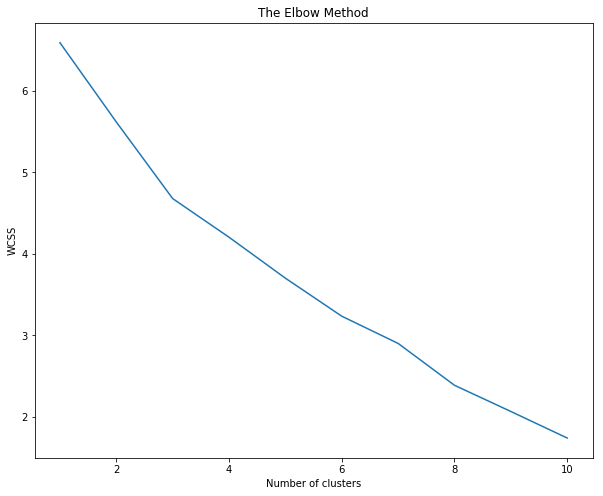

In [113]:
# find the appropriate cluster number
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

charlotte_grouped_clustering = charlotte_grouped.drop('ZIP Code', 1)

plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(charlotte_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Run *k*-means to cluster the neighborhood into 5 clusters.

In [122]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(charlotte_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

In [132]:
# add clustering labels
#zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

charlotte_merged = new_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
charlotte_merged = charlotte_merged.join(zipcodes_venues_sorted.set_index('ZIP Code'), on='ZIP Code')

print(charlotte_merged.shape)
charlotte_merged = charlotte_merged.dropna()
charlotte_merged['Cluster Labels'] = charlotte_merged['Cluster Labels'].astype(int)
print(charlotte_merged.shape)
charlotte_merged 


(25, 16)
(21, 16)


,ZIP Code,City,Population,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28202,Charlotte,11195.0,-80.839331,35.234558,0,American Restaurant,Video Store,Art Gallery,Gym,Performing Arts Venue,Park,Pub,Cycle Studio,Gas Station,Tapas Restaurant
1,28203,Charlotte,11315.0,-80.875865,35.202613,0,Summer Camp,Furniture / Home Store,Convenience Store,Fried Chicken Joint,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop
2,28204,Charlotte,4796.0,-80.827106,35.217039,0,New American Restaurant,Theater,Greek Restaurant,Shipping Store,Nightclub,Noodle House,Park,College Theater,Peruvian Restaurant,Pizza Place
3,28205,Charlotte,43931.0,-80.798422,35.207553,0,Hockey Arena,Bowling Alley,Trail,Fast Food Restaurant,Convention Center,Bar,Convenience Store,Gym,Electronics Store,Cycle Studio
4,28206,Charlotte,11898.0,-80.828205,35.250124,0,American Restaurant,Grocery Store,Discount Store,Fried Chicken Joint,Cycle Studio,Deli / Bodega,Department Store,Dog Run,Donut Shop,Drugstore
5,28207,Charlotte,9280.0,8.866428,53.066673,0,Supermarket,Hostel,Turkish Restaurant,Tram Station,Bookstore,Fried Chicken Joint,Cycle Studio,Deli / Bodega,Department Store,Discount Store
7,28209,Charlotte,20317.0,-80.875952,35.173773,0,Pizza Place,Department Store,Pharmacy,Latin American Restaurant,Discount Store,Chinese Restaurant,Brewery,Breakfast Spot,Mexican Restaurant,Soccer Field
8,28210,Charlotte,42263.0,-80.847199,35.126205,0,Playground,Pool,Electronics Store,Convention Center,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop
10,28212,Charlotte,38457.0,-80.744359,35.194593,0,Home Service,Seafood Restaurant,Convenience Store,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop,Drugstore
12,28214,Charlotte,34721.0,-80.956869,35.225226,2,Scenic Lookout,Wings Joint,Convenience Store,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop,Drugstore




Finally, let's visualize the resulting clusters


In [137]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

loc = getLocation("Charlotte, NC")

# create map
map_clusters = folium.Map(location=[loc.latitude, loc.longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(charlotte_merged['Latitude'], charlotte_merged['Longitude'], charlotte_merged['ZIP Code'], charlotte_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]


#### Cluster 2

In [135]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,1,2] + list(range(5, toronto_merged.shape[1]))]]


NameError: name 'toronto_merged' is not defined

#### Cluster 3

In [136]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 2, charlotte_merged.columns[[0,1,2] + list(range(5, charlotte_merged.shape[1]))]]


,ZIP Code,City,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,28214,Charlotte,34721.0,2,Scenic Lookout,Wings Joint,Convenience Store,Cycle Studio,Deli / Bodega,Department Store,Discount Store,Dog Run,Donut Shop,Drugstore


#### Cluster 4

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]


#### Cluster 5

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]
